门控循环单元(GRU)
起因: 不是每个观察值都同等重要; 有时我们需要仅记住相关的观察值
如何实现这个想法: 
我们需要
能关注的机制(更新门)Zt
能遗忘的机制(重置门)Rt
t-1进入下一层后, 会分别进入两个门中, 进行运算: 相当于多了两个全连接层, 使用sigmoid函数获得输出

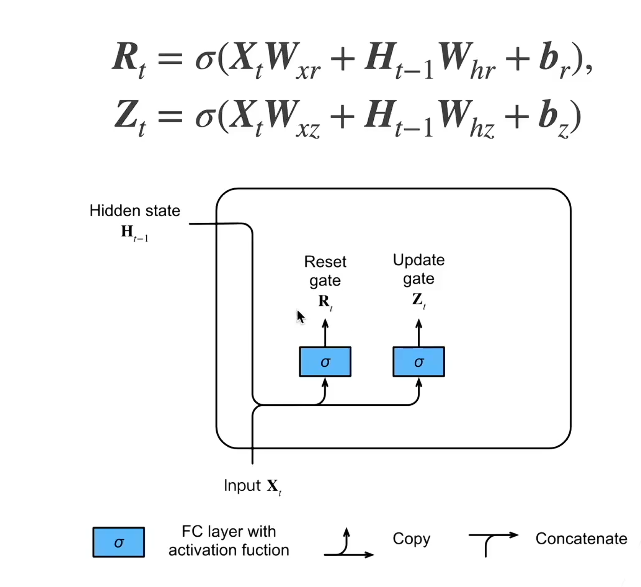

候选隐藏状态: 暂定的隐藏状态, 还要进行进一步处理
Rt中分布着0-1的数据, 用于决定遗忘Ht-1中的哪些数据, 记住哪些数据. (图中符号表示让各个对应项相乘)

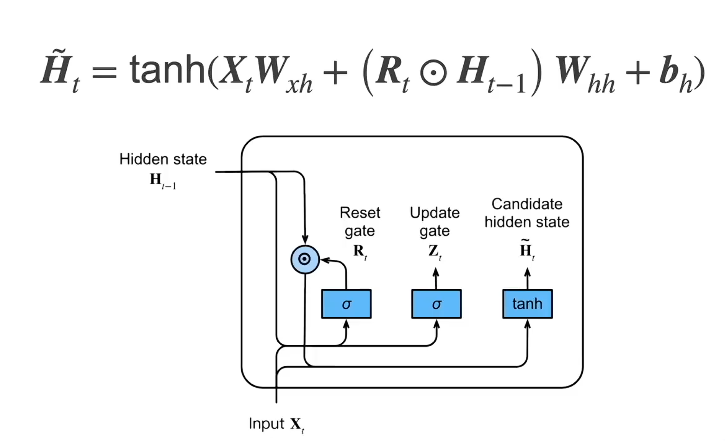

隐状态: 表示更新的幅度, Zt中数据越接近1, 更新的越少; 数据越接近0, 更新的越多
当Rt全为1, Zt全为0时, 就是RNN

总结: Rt, Zt由Xt和Ht-1得出, 负责控制遗忘程度和更新程度; 它们有各自的权重W
Ht-1, Xt和Rt先一步计算得到Ht~, 这里会遗忘一些Ht-1的内容再计算
然后再参考Zt, 决定要更多依赖Ht-1还是Ht~得出Ht

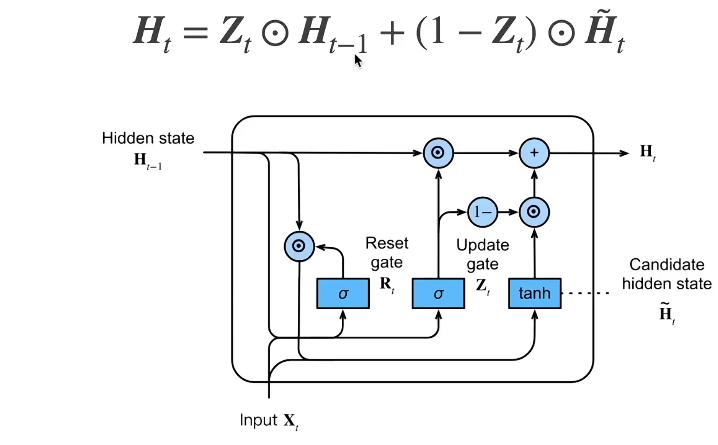
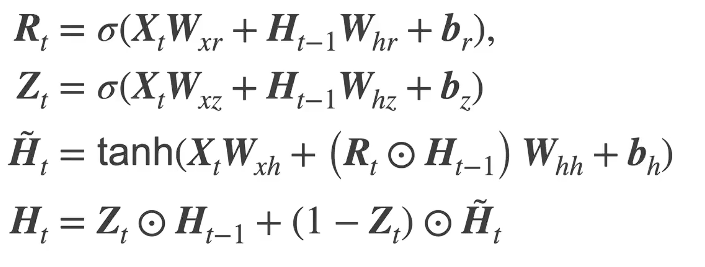

In [ ]:
# 代码实现
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    # 创建参数的辅助函数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    # 使用辅助函数初始化Z, R, H使用的可供学习的参数
    W_xz, W_hz, b_z = three()
    W_xr, W_hr, b_r = three()
    W_xh, W_hh, b_h = three()
    # 输出层参数初始化
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [ ]:
# 定义隐藏状态的初始化函数
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [ ]:
# 定义门控循环单元模型
def gru(inputs, state, params):
    # 取出params
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    # 初始隐状态
    H, = state
    outputs = []
    for X in inputs:
        # Z, R的计算
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        # 候选隐藏状态的计算
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        # H, Y的计算
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [ ]:
# 训练
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [ ]:
# 简洁实现: 直接nn.GRU
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

长短期记忆网络(LSTM)
忘记门: 将值朝0减少
输入门: 决定是否忽略输入数据
输出门: 决定是否使用隐藏状态

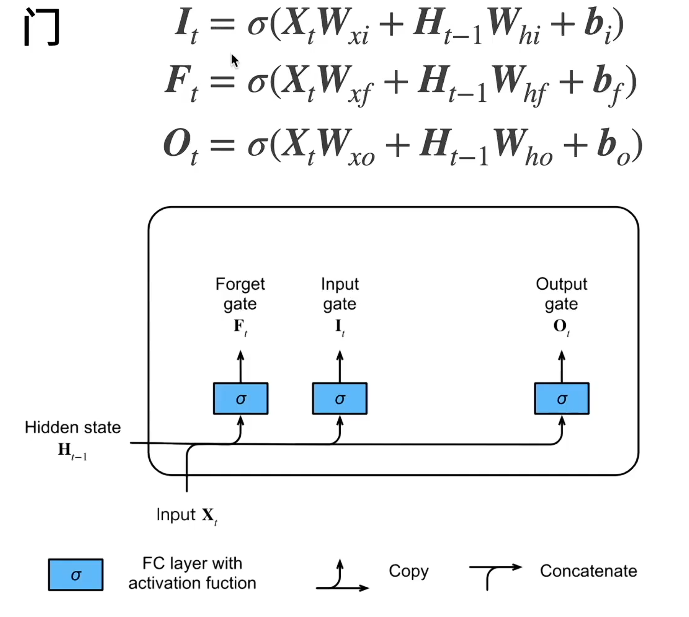

候选记忆单元Ct: 一个和H一样的新状态, 主要负责记忆功能
Ct的计算跟GRU中Ht的计算很像:

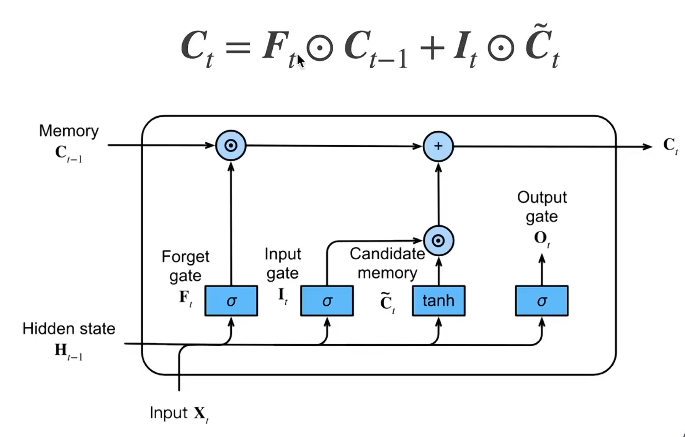

隐状态的计算: 对Ct再进行一次tanh, 并根据output(Ot)决定输出程度

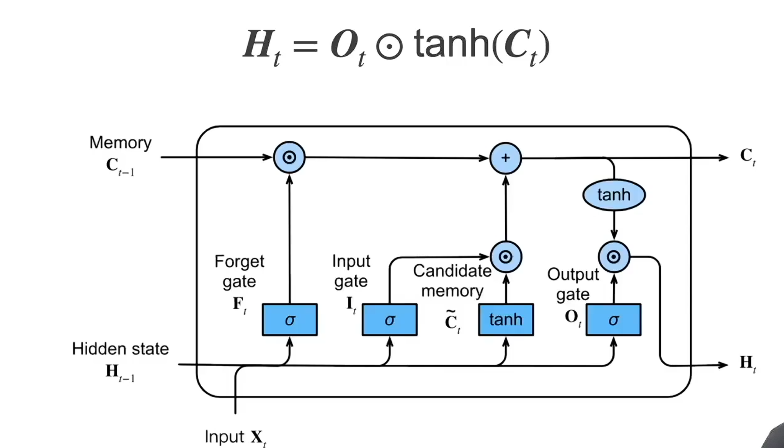
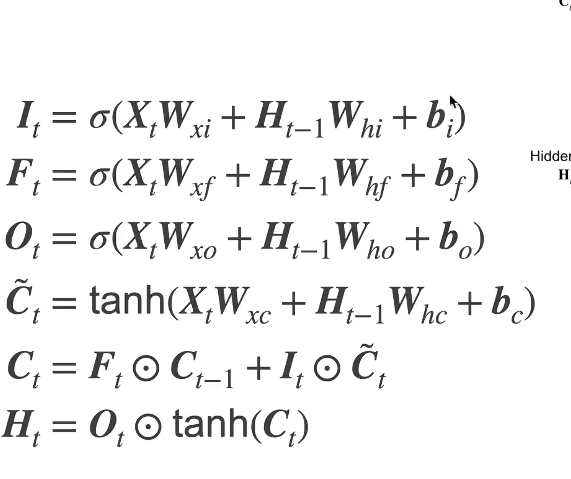

Xt和Ht-1得到Ct~, Ct-1和Ct~进过I和F的取舍得到了Ct, 而Ct再被Ot进行取舍才得到了Ht

In [ ]:
# 代码实现
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# 更多的初始化
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()
    W_xf, W_hf, b_f = three()
    W_xo, W_ho, b_o = three()
    W_xc, W_hc, b_c = three()
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [ ]:
# 初始化函数, 这里不仅初始化了H, 还初始化了C
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [ ]:
# 实际模型, 代入上面的计算步骤
def lstm(inputs, state, params):
    [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

In [ ]:
# 训练过程
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [ ]:
# 简洁实现: 直接 nn.LSTM
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

深度循环神经网络: 使用更多的隐藏层来获取更多的非线性

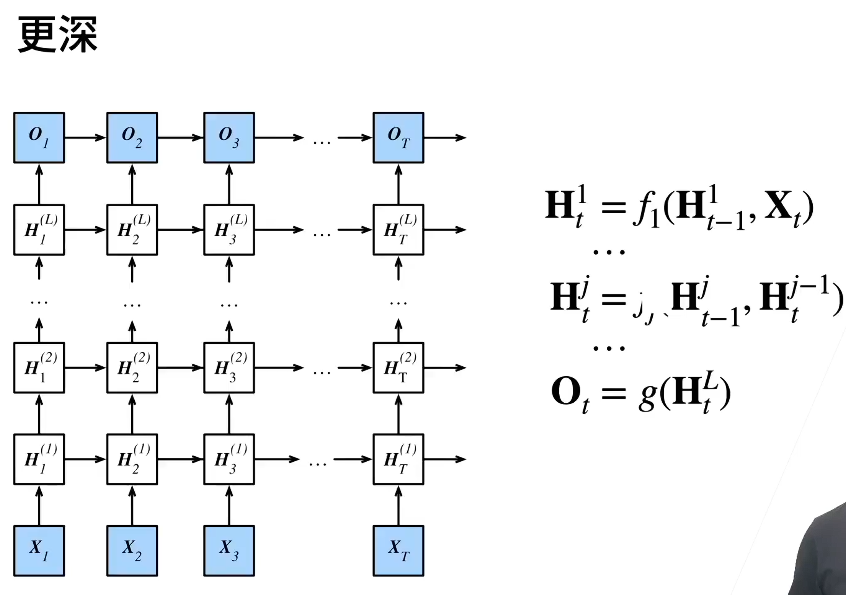

In [ ]:
# 代码实现
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
# 通过num_layers的值来设定隐藏层数
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

In [ ]:
# 训练
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

双向循环神经网络
在预测一句话时, RNN只结合了上文, 没有结合下文
所以在一些填空的场合, 我们可以结合上文, 也要结合下文
Ht-1和Xt联合作用得到Ht; 同时, Ht和Xt-1联合作用得到Xt-1
最后合并两个方向的隐状态得到输出

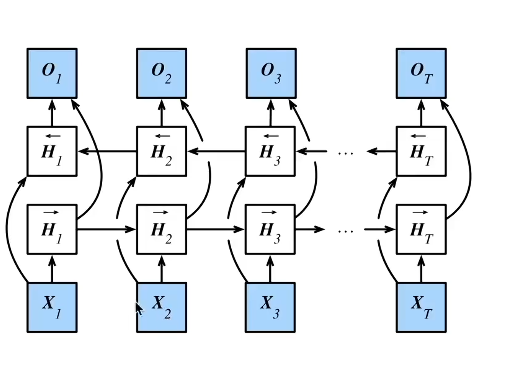
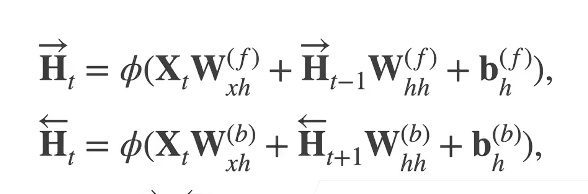
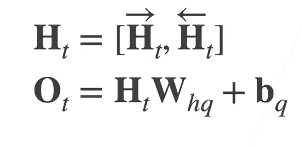

In [ ]:
# bidirectional=True
# 但是双向神经网络不太好用语预测未来, 应该有上下文才行, 不然性能会下降
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)